# Benchmark: Schoof in-house dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import protvi.benchmark_models as bm
import protvi.plots as pl
import protvi.utils as utils
import scanpy as sc
import scvi
import seaborn as sns
import torch
from protvi.model import PROTVI

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(0)
scvi.settings.seed = 0

Seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../data/processed/"

CARRIER_DATA_PATH = os.path.join(DATA_DIR, "schoof_inhouse_carrier.h5ad")
CELLS_DATA_PATH = os.path.join(DATA_DIR, "schoof_inhouse_hBM_raw.h5ad")

In [3]:
def renamer(name: str) -> str:
    return name.lower().replace(" ", "_")

In [4]:
adata = sc.read_h5ad(CELLS_DATA_PATH)

#adata.X = adata.layers["raw_sn"].copy() @TODO: why are X and layers["raw_sn"] different?
adata.X[adata.X == 0] = np.nan
adata.X = np.log(adata.X)
adata.layers["raw"] = adata.X.copy()

adata.obs.columns = [renamer(col) for col in adata.obs.columns]
adata.var.columns = [renamer(col) for col in adata.var.columns]

uns = adata.uns.copy()
adata.uns = {}
for key, val in uns.items():
    adata.uns[renamer(key)] = val

del adata.layers["raw_sn"]

In [5]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [6]:
carrier_adata = sc.read_h5ad(CARRIER_DATA_PATH)

carrier_adata.obs.columns = [renamer(col) for col in carrier_adata.obs.columns]
carrier_adata.var.columns = [renamer(col) for col in carrier_adata.var.columns]

carrier_adata = carrier_adata[:, adata.var_names]

In [7]:
carrier_adata.X[carrier_adata.X == 0] = np.nan
carrier_adata.X = np.log(carrier_adata.X)
carrier_adata.layers["raw"] = carrier_adata.X.copy()

In [8]:
"""
carrier_adata.X = carrier_adata.layers["raw"].copy()

carrier_channels = carrier_adata.obs["file_id"].unique()
channels = adata.obs["file_id"].unique()

assert np.isin(channels, carrier_channels).all()

carrier_agg = {
    channel: np.nanmean(carrier_adata[carrier_adata.obs["file_id"] == channel].X, axis=0) for channel in carrier_channels
}

for channel in channels:
    adata[adata.obs["file_id"] == channel].X /= carrier_agg[channel]

adata.X[np.isnan(adata.X)] = 0
"""

'\ncarrier_adata.X = carrier_adata.layers["raw"].copy()\n\ncarrier_channels = carrier_adata.obs["file_id"].unique()\nchannels = adata.obs["file_id"].unique()\n\nassert np.isin(channels, carrier_channels).all()\n\ncarrier_agg = {\n    channel: np.nanmean(carrier_adata[carrier_adata.obs["file_id"] == channel].X, axis=0) for channel in carrier_channels\n}\n\nfor channel in channels:\n    adata[adata.obs["file_id"] == channel].X /= carrier_agg[channel]\n\nadata.X[np.isnan(adata.X)] = 0\n'

## Data Exploration

Let's see if we can decide which annotation is the batch effect.

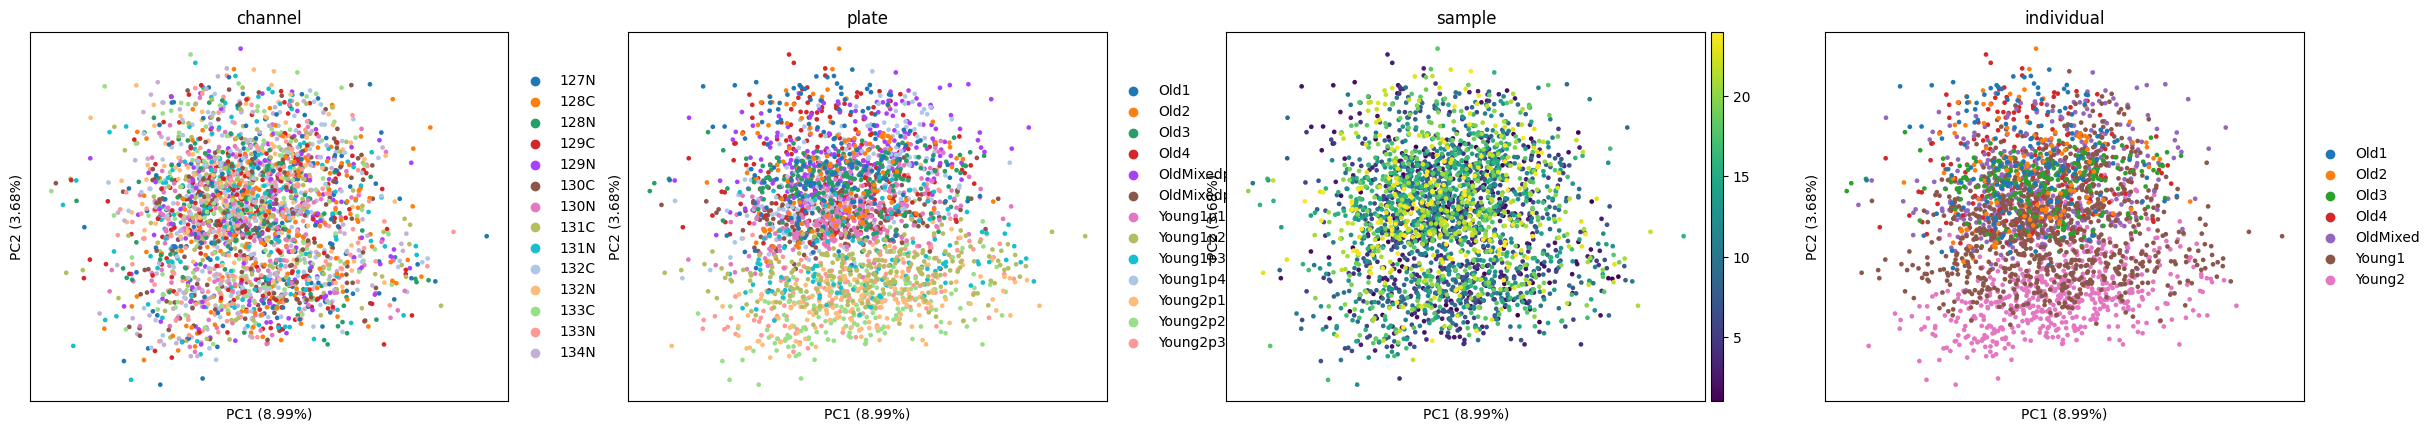

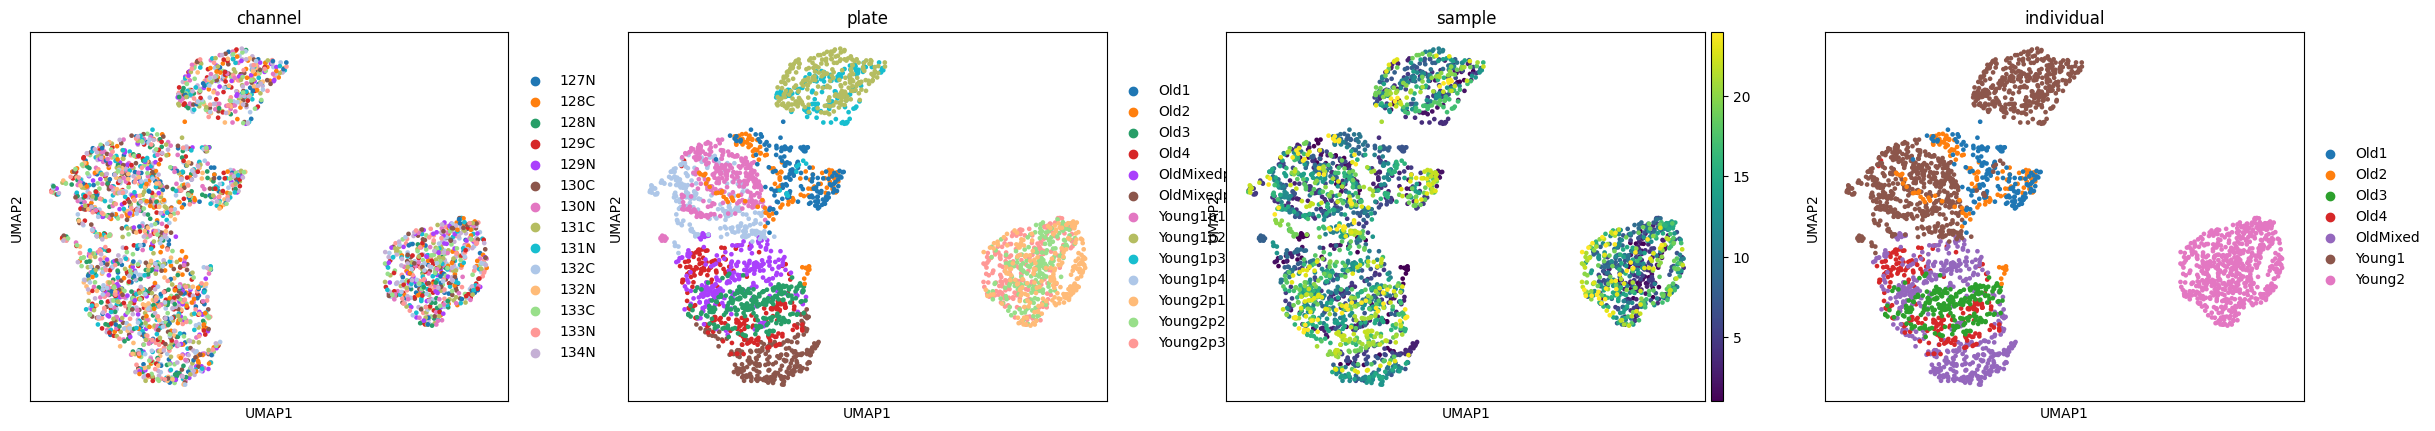

In [9]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["channel", "plate", "sample", "individual"],
    components=["1,2"],
)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["channel", "plate", "sample", "individual"],
)

## PROTVI

### Training

Let's now train the model.

In [10]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [11]:
PROTVI.setup_anndata(adata, batch_key="plate") #file_id

model = PROTVI(adata, log_variational=False, n_hidden=32)
#model.view_anndata_setup()

Let's train the model.

In [12]:
model.train(max_epochs=2000, plan_kwargs={"mechanism_weight": 0, "lr": 1e-3}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 10, "max_kl_weight": 10})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 22/2000:   1%|          | 21/2000 [00:14<19:08,  1.72it/s, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.21e+3]

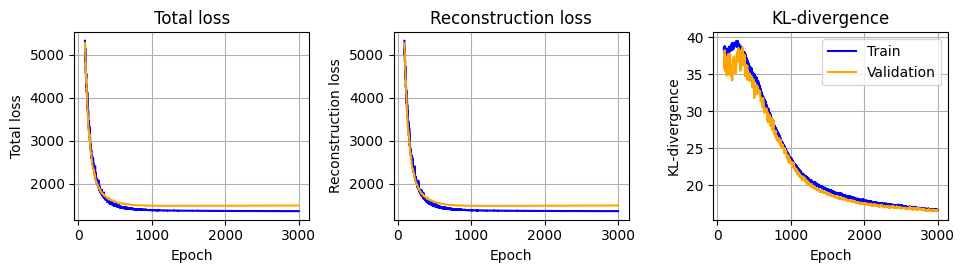

In [ ]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

### Evaluation on training set

In [ ]:
x_est, p_est = model.impute()

x_data = adata.layers["raw_sn"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

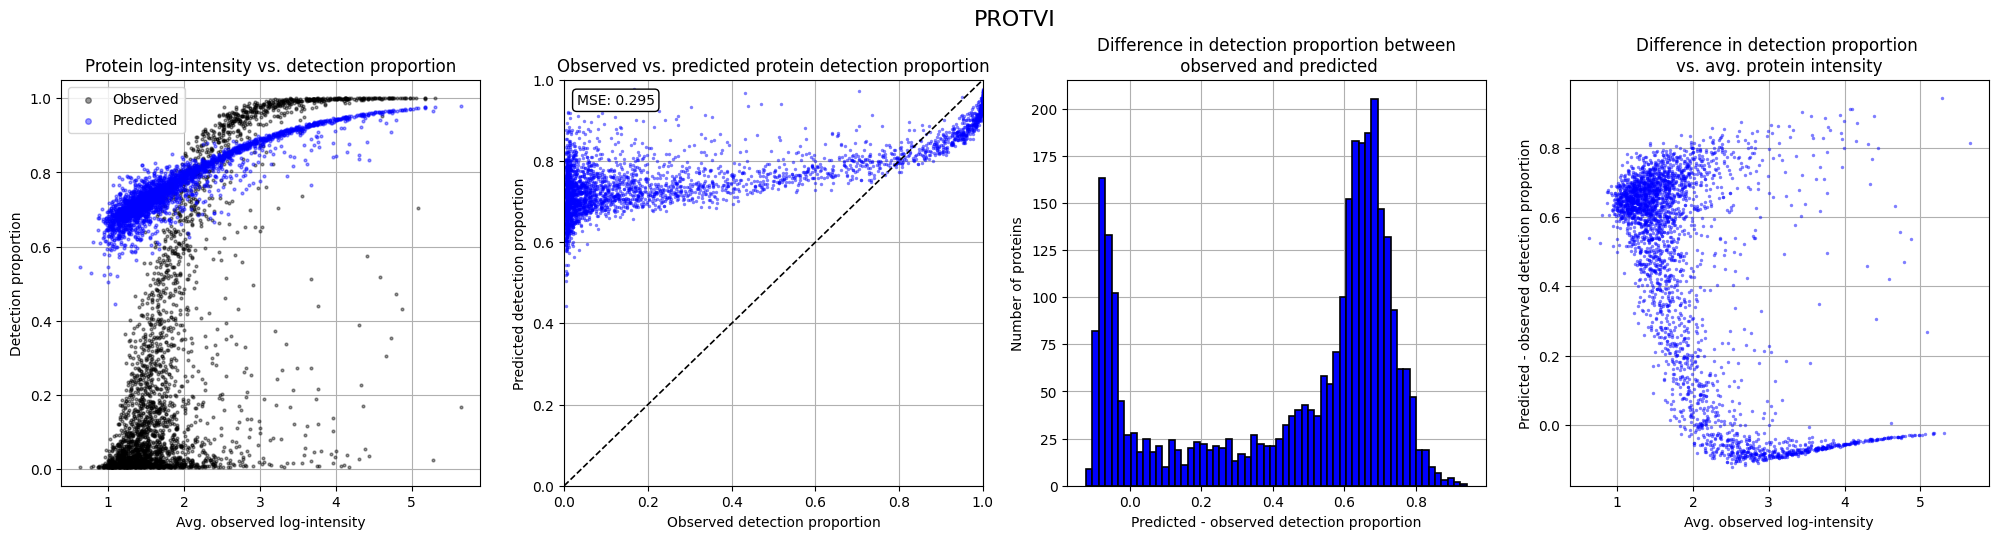

In [ ]:
pl.plot_protein_detection_proportion_panel(x_data, p_est)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

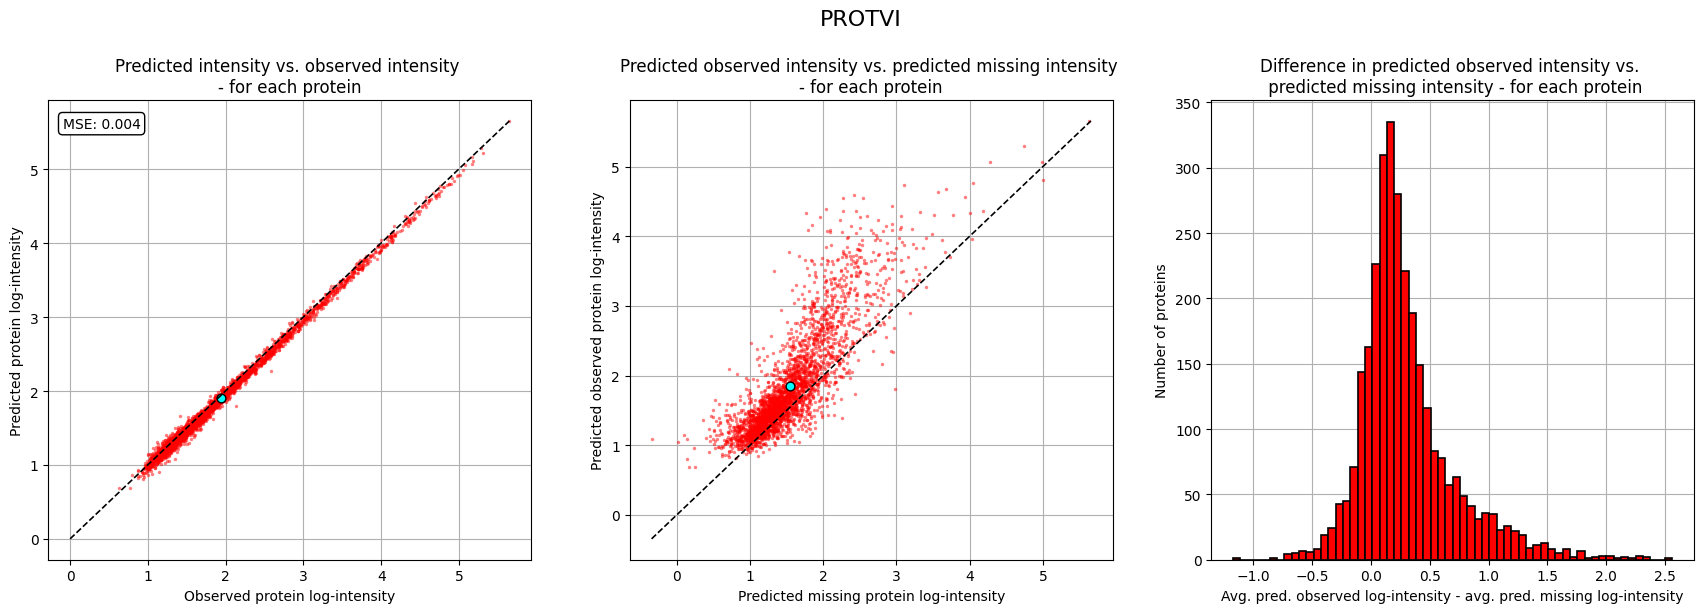

In [ ]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [ ]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

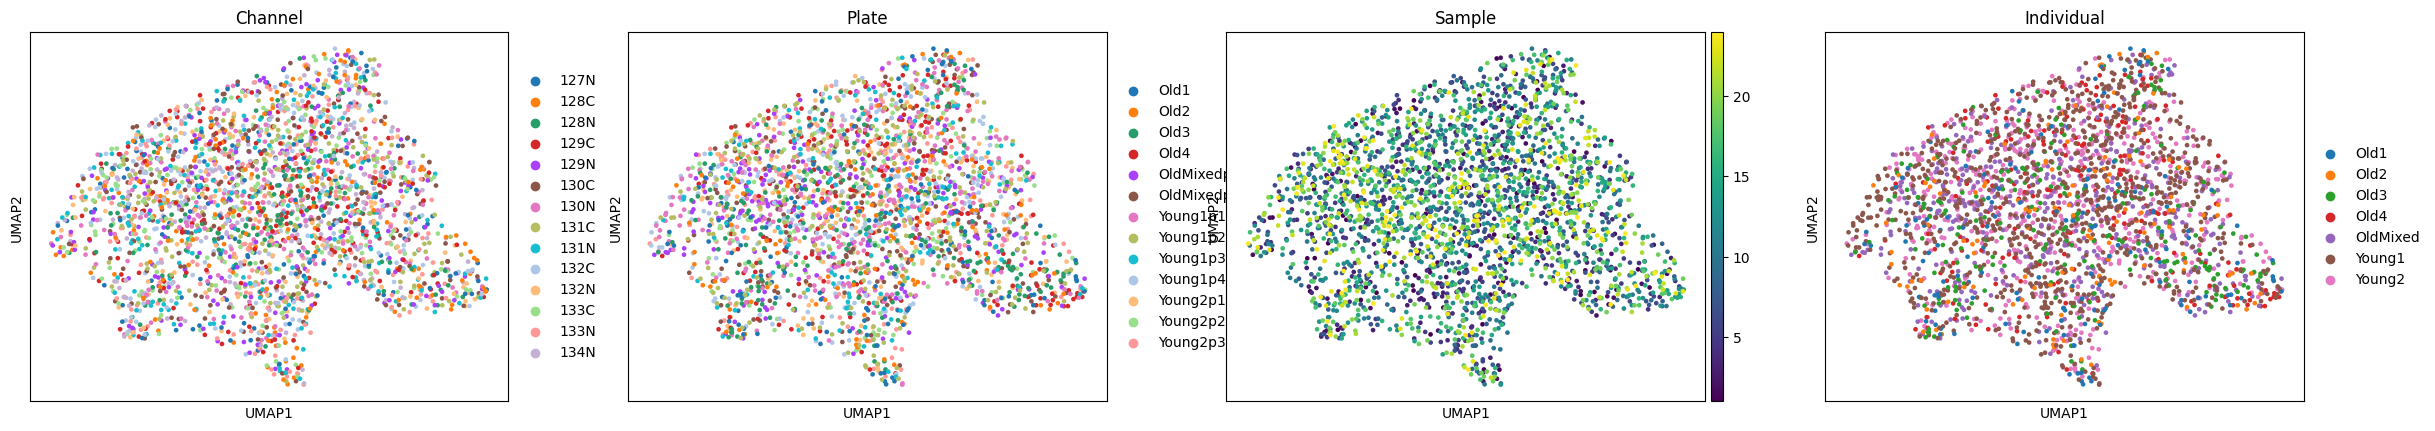

In [ ]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Channel", "Plate", "Sample", "Individual"], 
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

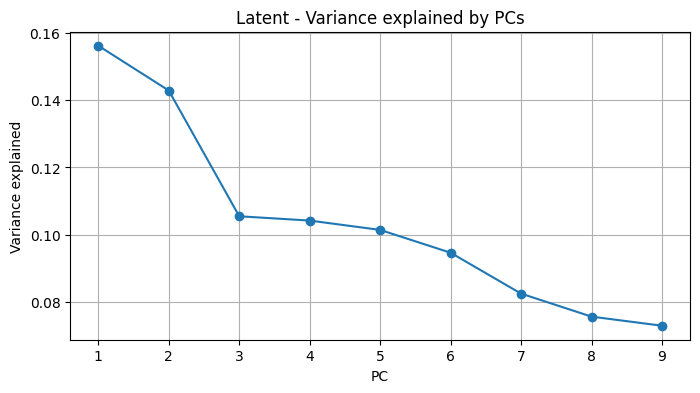

In [ ]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

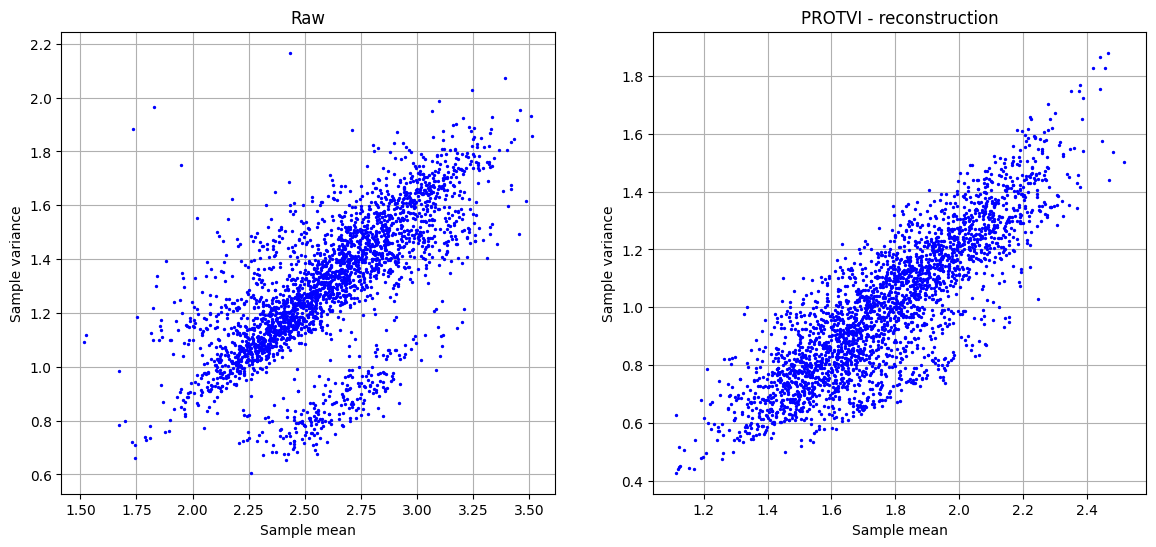

In [ ]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["raw_sn"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [ ]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [ ]:
r_adata = utils.prepare_anndata_for_R(adata)

In [ ]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw_sn")
dpcfit <- dpc(X)

In [ ]:
protdp_result = robjects.r("dpcfit")

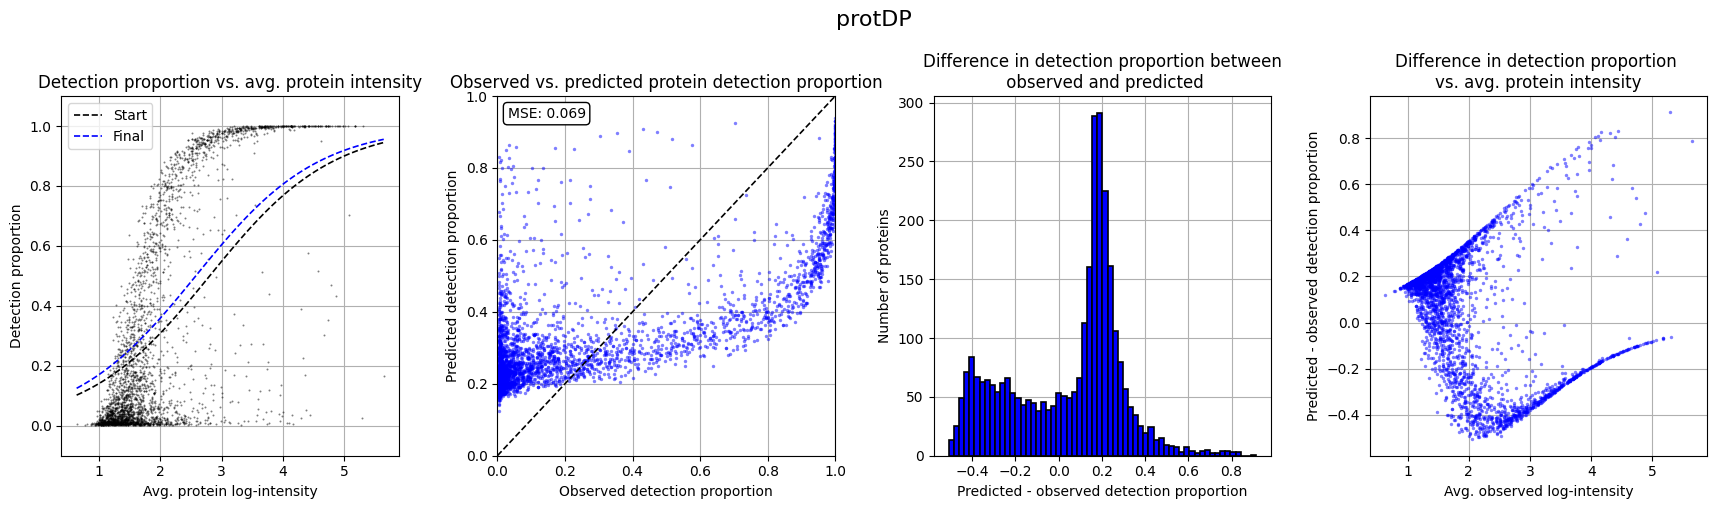

In [ ]:
pl.plot_protein_detection_proportion_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_38247/1935104467.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


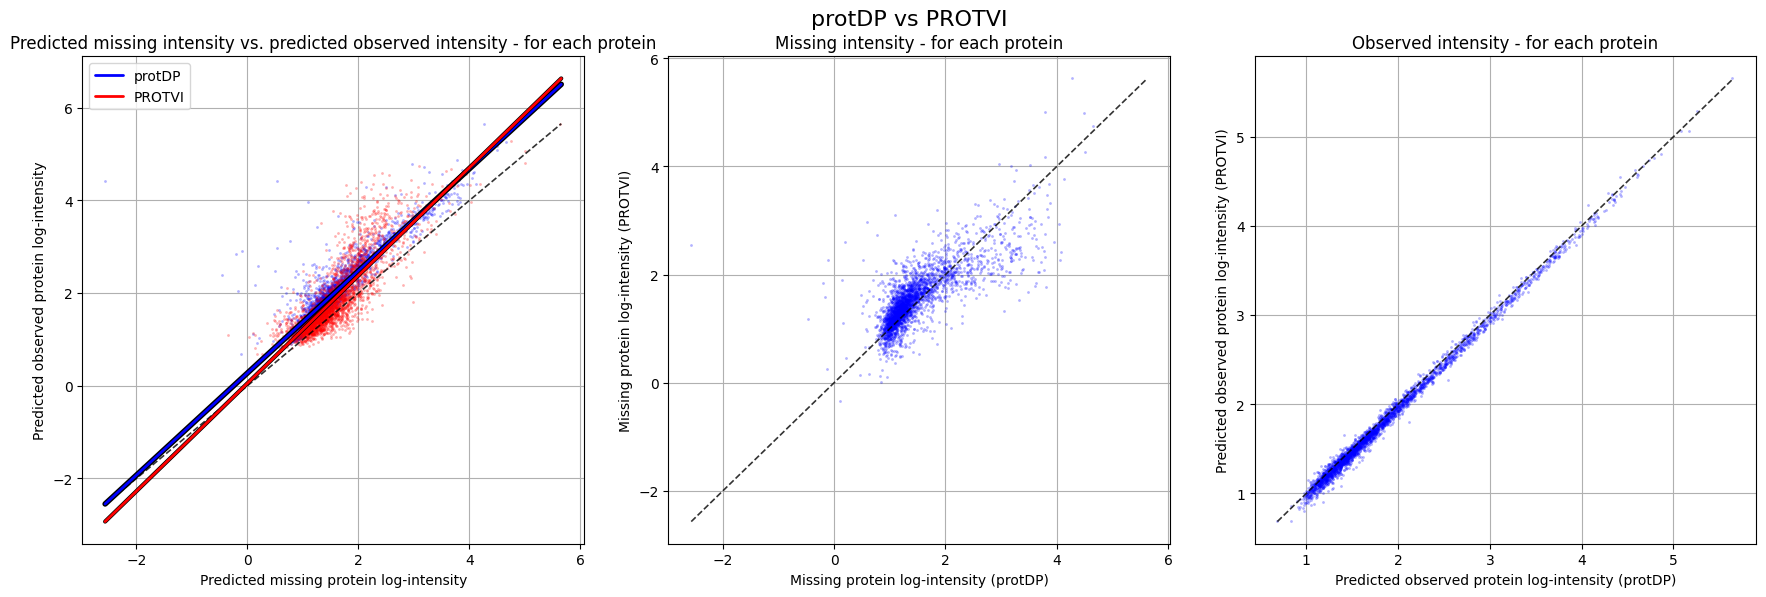

In [ ]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

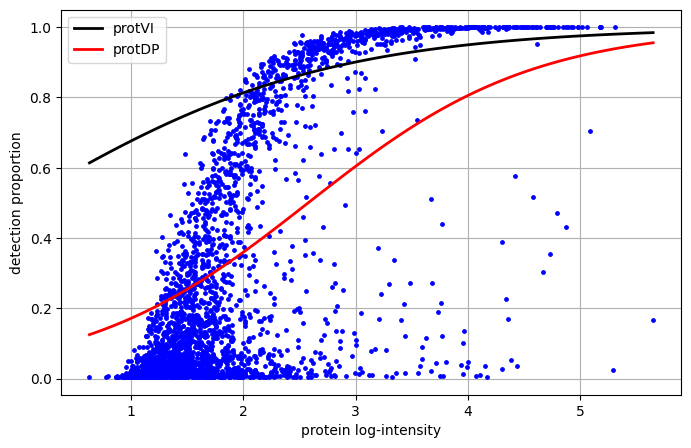

In [ ]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_data, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_data), axis=0)
    p_est_protein = p_est.mean(axis=0)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_data, ax=ax)

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()